# Motif analysis with ChromVAR for E vs V snATAC-seq
- https://stuartlab.org/signac/articles/mouse_brain_vignette

## Set up correct conda environment


In [1]:
.libPaths('/home/groups/tttt/xjluo/miniconda3/envs/single_cell_Seurat_v5/lib/R/library')
.libPaths()

[1] "/home/groups/tttt/xjluo/miniconda3/envs/single_cell_Seurat_v5/lib/R/library"
[2] "/home/users/xjluo/miniconda3/envs/jupyter_env/lib/R/library"

## Load packages

In [2]:
library(tidyverse)
library(viridis)
library(Seurat)
library(Signac)
library(Azimuth)
library(EnsDb.Mmusculus.v79)
library(BSgenome.Mmusculus.UCSC.mm10)
library(ggpointdensity)
library(ggExtra)

library(chromVAR)
library(JASPAR2020)
library(TFBSTools)
library(patchwork)
library(cowplot)

set.seed(1234)
options(repr.matrix.max.cols=100, repr.matrix.max.rows=50)
options(warn=-1)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: viridisLite

Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t


Registered S3 method overwritten by 'SeuratDisk':
  method            from  
  as.sparse.H5Group Seurat



Attaching shinyBS

Loading required package: ensembldb

Loading required package: BiocGenerics


Attaching package: 'BiocGenerics'


The following ob

In [3]:
sessionInfo()

R version 4.3.3 (2024-02-29)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /home/users/xjluo/miniconda3/envs/jupyter_env/lib/libopenblasp-r0.3.21.so;  LAPACK version 3.9.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: America/Los_Angeles
tzcode source: system (glibc)

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] cowplot_1.1.3                      patchwork_1.2.0                   
 [3] TFBSTools_1.38.0                   JASPAR2020_0.99.10                
 [5] chromVAR_1.24.0                    gg

In [4]:
sample1 <- 'E1_V1'
sample2 <- 'E2_V2'

## STEP 0: Paths

In [5]:
data_master_dir <- '/oak/stanford/groups/tttt/collaboration/jin/240821_ATAC'

data_master_dir

[1] "/oak/stanford/groups/tttt/collaboration/jin/240821_ATAC"

In [6]:
merge_savedir <- paste0(data_master_dir, '/xjluo_analysis/step2_merge')

merge_savedir

[1] "/oak/stanford/groups/tttt/collaboration/jin/240821_ATAC/xjluo_analysis/step2_merge"

In [7]:
# E1+V1+E2+V2 merged object (no cell type labels)
E_V.atac.obj.path <- paste0(merge_savedir, '/E_V/', sample1, '_', sample2, '_', 'merged.rds')

E_V.atac.obj.path

[1] "/oak/stanford/groups/tttt/collaboration/jin/240821_ATAC/xjluo_analysis/step2_merge/E_V/E1_V1_E2_V2_merged.rds"

In [8]:
# save output (labeled) object in this folder
savedir <- paste0(data_master_dir, '/xjluo_analysis/step2_merge')

savedir

[1] "/oak/stanford/groups/tttt/collaboration/jin/240821_ATAC/xjluo_analysis/step2_merge"

## STEP 1: Load objects

In [9]:
E_V.merged.atac.obj <- readRDS(E_V.atac.obj.path)

In [10]:
E_V.merged.atac.obj

An object of class Seurat 
385824 features across 9004 samples within 1 assay 
Active assay: ATAC (385824 features, 385824 variable features)
 2 layers present: counts, data
 2 dimensional reductions calculated: lsi, umap

In [11]:
colnames(E_V.merged.atac.obj@meta.data)

[1] "orig.ident"            "nCount_ATAC"           "nFeature_ATAC"        
 [4] "nucleosome_signal"     "nucleosome_percentile" "TSS.enrichment"       
 [7] "TSS.percentile"        "ATAC_snn_res.1.2"      "seurat_clusters"      
[10] "dataset"               "highlight"

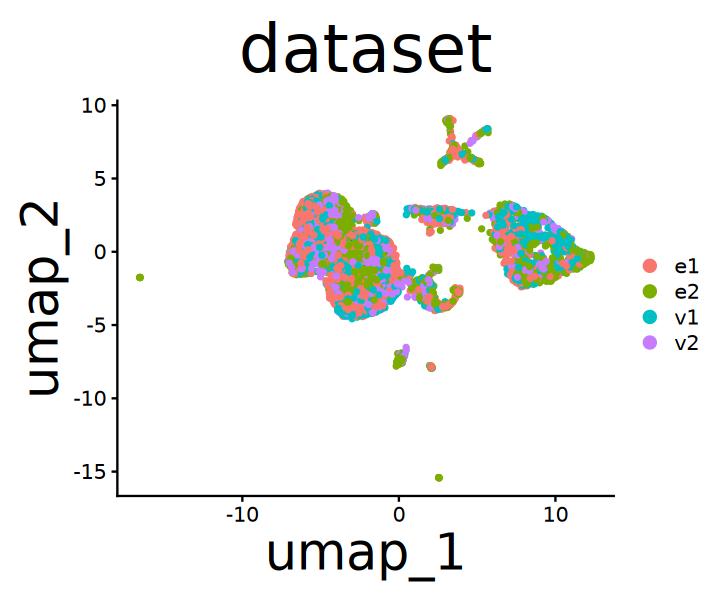

In [12]:
options(repr.plot.width=6, repr.plot.height=5)

DimPlot(E_V.merged.atac.obj, shuffle=TRUE, label = TRUE, repel = TRUE, pt.siz=1, label.size=0, group.by = 'dataset', raster=FALSE) + theme(plot.title = element_text(size=40),
                                                                                                                                         axis.title = element_text(size=30)
                                                                                                                                        )
     

     
     
     

## STEP 2: chromVAR

In [13]:
# Get a list of motif position frequency matrices from the JASPAR database
pfm <- getMatrixSet(
  x = JASPAR2020,
  opts = list(collection = "CORE", tax_group = 'vertebrates', all_versions = FALSE)
)

In [14]:
# add motif information
DefaultAssay(E_V.merged.atac.obj) <- 'ATAC'

E_V.merged.atac.obj <- AddMotifs(
  object = E_V.merged.atac.obj,
  genome = BSgenome.Mmusculus.UCSC.mm10,
  pfm = pfm
)

Building motif matrix

Finding motif positions

Creating Motif object



In [15]:
E_V.merged.atac.obj <- RunChromVAR(
  object = E_V.merged.atac.obj,
  genome = BSgenome.Mmusculus.UCSC.mm10
)

Computing GC bias per region

Selecting background regions

Computing deviations from background

Constructing chromVAR assay



In [16]:
E_V.merged.atac.obj

An object of class Seurat 
386570 features across 9004 samples within 2 assays 
Active assay: ATAC (385824 features, 385824 variable features)
 2 layers present: counts, data
 1 other assay present: chromvar
 2 dimensional reductions calculated: lsi, umap

## Save object

In [19]:
save_path <- paste0(savedir, '/', sample1, '_', sample2, '_', 'merged_chromvar.rds')

save_path

[1] "/oak/stanford/groups/tttt/collaboration/jin/240821_ATAC/xjluo_analysis/step2_merge/E1_V1_E2_V2_merged_chromvar.rds"

In [20]:
saveRDS(E_V.merged.atac.obj, file = save_path)

print('Done')

[1] "Done"


# END